In [20]:
import copy
import datetime as dt
import importlib # needed so that we can reload packages
import matplotlib.pyplot as plt
import os, os.path
import numpy as np
import pandas as pd
import pathlib
import sys
import time
from typing import Union
import warnings
from datetime import datetime
warnings.filterwarnings("ignore")

##  IMPORT SISEPUEDE EXAMPLES AND TRANSFORMERS

from sisepuede.manager.sisepuede_examples import SISEPUEDEExamples
from sisepuede.manager.sisepuede_file_structure import SISEPUEDEFileStructure
import sisepuede.core.support_classes as sc
import sisepuede.transformers as trf
import sisepuede.utilities._plotting as spu
import sisepuede.utilities._toolbox as sf

sys.path.append(os.path.join('../', 'utils'))

from TransformationUtils import ExcelYAMLHandler, StrategyCSVHandler
from GeneralUtils import GeneralUtils

In [21]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Initial Set up

Make sure to edit the config yaml under croatia/config_files/croatia_config.yaml

You can also create a new config yaml



In [22]:
g_utils = GeneralUtils()

In [23]:
##  SETUP DIRECTORIES

dir_cur = pathlib.Path(os.getcwd())
dir_data = dir_cur.joinpath("data")
dir_config = dir_cur.joinpath("config_files")
dir_transformations = dir_cur.joinpath("transformations")

In [24]:
yaml_file_path = os.path.join(dir_config, "croatia_config.yaml")
config_params = g_utils.get_yaml_values(yaml_file_path)

country_name = config_params['country_name']
ssp_input_file_name = config_params['ssp_input_file_name']
ssp_transformation_cw = config_params['ssp_transformation_cw']


Country Name: croatia
SSP Input File Name: sisepuede_inputs_croatia.csv
SSP Transformation CW: Copy of ssp_croatia_transformation_2024_11_25.xlsx


In [25]:
##  SETUP FILES: Edit the 

fp_data_base = dir_data.joinpath(ssp_input_file_name)


##  SETUP SOME SISEPUEDE STUFF

file_struct = SISEPUEDEFileStructure()

matt = file_struct.model_attributes
regions = sc.Regions(matt)
time_periods = sc.TimePeriods(matt)

### Making sure our input file has the correct format and correct columns
We use an example df with the complete fields and correct format to make sure our file is in the right shape

In [26]:
##  BUILD BASE INPUTS

df_inputs_raw = pd.read_csv(fp_data_base)

# pull example data to fill in gaps
examples = SISEPUEDEExamples()
df_inputs_example = examples.input_data_frame

In [27]:
df_inputs_example.head()

,region,time_period,avgload_trns_freight_tonne_per_vehicle_aviation,avgload_trns_freight_tonne_per_vehicle_rail_freight,avgload_trns_freight_tonne_per_vehicle_road_heavy_freight,avgload_trns_freight_tonne_per_vehicle_water_borne,avgmass_lvst_animal_buffalo_kg,avgmass_lvst_animal_cattle_dairy_kg,avgmass_lvst_animal_cattle_nondairy_kg,avgmass_lvst_animal_chickens_kg,...,ef_ippu_tonne_cf4_per_tonne_production_electronics,ef_ippu_tonne_cf4_per_tonne_production_metals,ef_ippu_tonne_c3f8_per_tonne_production_chemicals,ef_ippu_tonne_c3f8_per_tonne_production_electronics,ef_ippu_tonne_c4f10_per_mmm_gdp_product_use_ods_other,ef_ippu_tonne_c4f10_per_tonne_production_chemicals,ef_ippu_tonne_c6f14_per_mmm_gdp_product_use_ods_other,ef_ippu_tonne_c6f14_per_tonne_production_chemicals,ef_ippu_tonne_cc4f8_per_tonne_production_chemicals,ef_ippu_tonne_cc4f8_per_tonne_production_electronics
0,costa_rica,0,70.0,2923.0,31.751466,6468.0,322.900664,520.741388,310.599686,1.12759,...,0.000002,4.204879e-07,0.0,1.515048e-07,0.0,0.0,0.0,0.0,0.0,5.669821e-08
1,costa_rica,1,70.0,2923.0,31.751466,6468.0,322.900664,520.741388,310.599686,1.12759,...,0.000002,2.134675e-07,0.0,1.313925e-07,0.0,0.0,0.0,0.0,0.0,5.185820e-08
2,costa_rica,2,70.0,2923.0,31.751466,6468.0,322.900664,520.741388,310.599686,1.12759,...,0.000002,1.821067e-07,0.0,1.060066e-07,0.0,0.0,0.0,0.0,0.0,5.269348e-08
3,costa_rica,3,70.0,2923.0,31.751466,6468.0,322.900664,520.741388,310.599686,1.12759,...,0.000002,2.094712e-07,0.0,1.093024e-07,0.0,0.0,0.0,0.0,0.0,5.500450e-08
4,costa_rica,4,70.0,2923.0,31.751466,6468.0,322.900664,520.741388,310.599686,1.12759,...,0.000002,3.446161e-07,0.0,1.046451e-07,0.0,0.0,0.0,0.0,0.0,5.266081e-08


In [28]:
# Checks if there are any differences in columns between the example df and our df
g_utils.compare_dfs(df_inputs_example, df_inputs_raw)


Columns in df1 but not in df2: {'ef_enfu_stationary_combustion_tonne_n2o_per_tj_fuel_furnace_gas', 'nemomod_entc_emissions_activity_ratio_fuel_production_fp_petroleum_refinement_tonne_ch4_per_tj', 'nemomod_entc_emissions_activity_ratio_fuel_production_fp_natural_gas_tonne_n2o_per_tj', 'physparam_lvst_bo_mules_kg_ch4_kg_manure', 'ef_enfu_stationary_combustion_tonne_n2o_per_tj_fuel_biofuels', 'frac_agrc_n_in_below_ground_residue_tubers', 'regressionb_agrc_above_ground_residue_tubers_kg_per_ha', 'ef_enfu_combustion_tonne_co2_per_tj_fuel_crude', 'ef_enfu_stationary_combustion_tonne_n2o_per_tj_fuel_electricity', 'ratio_agrc_below_ground_to_above_ground_biomass_pulses', 'ef_enfu_stationary_combustion_tonne_ch4_per_tj_fuel_biomass', 'ef_soil_ef2_n_drained_managed_soils_n2o_temperate_forest_nutrient_poor_kg_n2on_ha', 'ef_soil_ef1_n_organic_amerndments_fertilizer_n2o_dry_climate', 'ef_enfu_stationary_combustion_tonne_ch4_per_tj_fuel_biogas', 'qty_soil_organic_c_stock_temperate_forest_nutrient_r

In [29]:
# Fixes differences and makes sure that our df is in the correct format.
# Note: Edit this if you need more changes in your df

df_inputs_raw = df_inputs_raw.rename(columns={'period':'time_period'})
df_inputs_raw_complete = g_utils.add_missing_cols(df_inputs_example, df_inputs_raw.copy())
df_inputs_raw_complete = df_inputs_raw_complete.drop(columns='iso_code3')
df_inputs_raw_complete.head()

,region,time_period,area_gnrl_country_ha,avgload_trns_freight_tonne_per_vehicle_aviation,avgload_trns_freight_tonne_per_vehicle_rail_freight,avgload_trns_freight_tonne_per_vehicle_road_heavy_freight,avgload_trns_freight_tonne_per_vehicle_water_borne,avgmass_lvst_animal_buffalo_kg,avgmass_lvst_animal_cattle_dairy_kg,avgmass_lvst_animal_cattle_nondairy_kg,...,nemomod_entc_input_activity_ratio_fuel_production_fp_hydrogen_electrolysis_water,nemomod_entc_input_activity_ratio_fuel_production_fp_hydrogen_reformation_ccs_electricity,energydensity_gravimetric_enfu_gj_per_tonne_fuel_ammonia,energydensity_gravimetric_enfu_gj_per_tonne_fuel_water,frac_trns_fuelmix_water_borne_ammonia,nemomod_entc_output_activity_ratio_fuel_production_fp_ammonia_production_ammonia,nemomod_entc_output_activity_ratio_fuel_production_fp_hydrogen_reformation_ccs_hydrogen,nemomod_entc_frac_min_share_production_fp_hydrogen_reformation_ccs,nemomod_entc_input_activity_ratio_fuel_production_fp_hydrogen_reformation_ccs_natural_gas,nemomod_entc_input_activity_ratio_fuel_production_fp_hydrogen_reformation_ccs_oil
0,croatia,0,8807000,70,2923,31.751466,6468,315,508,303,...,0.000004,0,18.6,0.00005,0.0,1,1,0.0,1.315,0.0
1,croatia,1,8807000,70,2923,31.751466,6468,315,508,303,...,0.000004,0,18.6,0.00005,0.0,1,1,0.0,1.315,0.0
2,croatia,2,8807000,70,2923,31.751466,6468,315,508,303,...,0.000004,0,18.6,0.00005,0.0,1,1,0.0,1.315,0.0
3,croatia,3,8807000,70,2923,31.751466,6468,315,508,303,...,0.000004,0,18.6,0.00005,0.0,1,1,0.0,1.315,0.0
4,croatia,4,8807000,70,2923,31.751466,6468,315,508,303,...,0.000004,0,18.6,0.00005,0.0,1,1,0.0,1.315,0.0


In [30]:
# Double checking that our df is in the correct shape (Empty sets should be printed to make sure everything is Ok!)
g_utils.compare_dfs(df_inputs_example, df_inputs_raw_complete)

Columns in df1 but not in df2: set()
Columns in df2 but not in df1: set()


In [31]:
# Checking if there are any columns with null values in it
columns_with_na = df_inputs_raw_complete.columns[df_inputs_raw_complete.isna().any()].tolist()

print(columns_with_na)

[]


#  Let's try building transformations using this


In [32]:
transformers = trf.transformers.Transformers(
    {},
    df_input = df_inputs_raw_complete,
)

##  Instantiate some transformations CAREFUL NOT TO OVERWRITE EXISTING TRANSFORMATIONS!!

In [33]:
# set an ouput path and instantiate
if not dir_transformations.exists():
    trf.instantiate_default_strategy_directory(
        transformers,
        dir_transformations,
    )


##  --HERE, CUSTOMIZE YOUR TRANSFORMATIONS AND STRATEGIES--
- go to `dir_transformers` and edit config files and `strategy_definitions.csv`
- then, go to next cell

### Customizing transformations and strategies files using TransformationUtils.py classes

In [34]:
# Generate new transformation files based on the excel mapping file. Change the excel file path for yours
cw_file_path = os.path.join(dir_data, ssp_transformation_cw)
excel_yaml_handler = ExcelYAMLHandler(excel_file=cw_file_path, yaml_directory='transformations')

In [35]:
excel_yaml_handler.process_yaml_files()

YAML file transformation_agrc_inc_conservation_agriculture.yaml for strategy strategy_WEM set to default because it does not have magnitude attribute
YAML file transformation_agrc_inc_conservation_agriculture.yaml for strategy strategy_WAM set to default because it does not have magnitude attribute
YAML file transformation_agrc_inc_conservation_agriculture.yaml for strategy strategy_NZ set to default because it does not have magnitude attribute
YAML file transformation_inen_shift_fuel_heat.yaml for strategy strategy_NZ set to default because it does not have magnitude attribute
YAML file transformation_lsmm_inc_management_cattle_pigs.yaml for strategy strategy_WEM set to default because it does not have magnitude attribute
YAML file transformation_lsmm_inc_management_cattle_pigs.yaml for strategy strategy_WAM set to default because it does not have magnitude attribute
YAML file transformation_lsmm_inc_management_cattle_pigs.yaml for strategy strategy_NZ set to default because it does n

In [36]:
# Creating new strategies by updating the strategy_definitions file.
# You can edit this to add yours, as many as you want.

csv_handler = StrategyCSVHandler('transformations/strategy_definitions.csv', 'transformations', '../utils/strategy_mapping.yaml')
csv_handler.add_strategy(strategy_group='PFLO', description='Croatia WEM scenario', yaml_file_suffix='WEM')
csv_handler.add_strategy(strategy_group='PFLO', description='Croatia WAM scenario', yaml_file_suffix='WAM')
csv_handler.add_strategy(strategy_group='PFLO', description='Croatia NZ scenario', yaml_file_suffix='NZ')
csv_handler.save_csv()

Added new row: {'strategy_id': 6006, 'strategy_code': 'PFLO:WEM', 'strategy': 'WEM', 'description': 'Croatia WEM scenario', 'transformation_specification': 'TX:TRNS:INC_EFFICIENCY_NON_ELECTRIC_STRATEGY_WEM|TX:LSMM:INC_MANAGEMENT_POULTRY_STRATEGY_WEM|TX:TRNS:SHIFT_MODE_REGIONAL_STRATEGY_WEM|TX:TRDE:DEC_DEMAND_STRATEGY_WEM|TX:WASO:DEC_CONSUMER_FOOD_WASTE_STRATEGY_WEM|TX:TRNS:SHIFT_MODE_PASSENGER_STRATEGY_WEM|TX:TRNS:INC_OCCUPANCY_LIGHT_DUTY_STRATEGY_WEM|TX:TRNS:INC_EFFICIENCY_ELECTRIC_STRATEGY_WEM|TX:LNDU:DEC_SOC_LOSS_PASTURES_STRATEGY_WEM|TX:TRNS:SHIFT_FUEL_MARITIME_STRATEGY_WEM|TX:TRNS:SHIFT_FUEL_MEDIUM_DUTY_STRATEGY_WEM|TX:SCOE:DEC_DEMAND_HEAT_STRATEGY_WEM|TX:ENTC:TARGET_RENEWABLE_ELEC_STRATEGY_WEM|TX:LNDU:INC_SILVOPASTURE_STRATEGY_WEM|TX:SCOE:INC_EFFICIENCY_APPLIANCE_STRATEGY_WEM|TX:INEN:INC_EFFICIENCY_ENERGY_STRATEGY_WEM|TX:TRNS:SHIFT_FUEL_RAIL_STRATEGY_WEM|TX:PFLO:INC_IND_CCS_STRATEGY_WEM|TX:AGRC:INC_CONSERVATION_AGRICULTURE_STRATEGY_WEM|TX:TRNS:SHIFT_MODE_FREIGHT_STRATEGY_WEM|TX:S

In [43]:
# Set up the strategy codes you wish to run in ssp
strategies_to_run = [0, 6006, 6007, 6008]

### We finished adding new transformation files and strategies so lets load them back

In [37]:
# then, you can load this back in after modifying (play around with it)
transformations = trf.Transformations(
    dir_transformations,
    transformers = transformers,
)
tab = transformations.attribute_transformation.table

In [38]:
#  build the strategies -- will export to path
t0 = time.time()
strategies = trf.Strategies(
    transformations,
    export_path = "transformations",
    prebuild = True,
)

t_elapse = sf.get_time_elapsed(t0)
print(f"Strategies defined at {strategies.transformations.dir_init} initialized in {t_elapse} seconds")

Strategies defined at /home/tony/ssp/sisepuede_region_nbs_tony_ver/croatia/transformations initialized in 4.85 seconds


In [ ]:
strategies.attribute_table

,strategy_id,strategy_code,strategy,description,transformation_specification,baseline_strategy_id
0,0,BASE,Strategy TX:BASE,NaN,TX:BASE,1
1,1000,AGRC:DEC_CH4_RICE,Singleton - Default Value - AGRC: Improve rice...,NaN,TX:AGRC:DEC_CH4_RICE,0
2,1001,AGRC:DEC_EXPORTS,Singleton - Default Value - AGRC: Decrease Exp...,NaN,TX:AGRC:DEC_EXPORTS,0
3,1002,AGRC:DEC_LOSSES_SUPPLY_CHAIN,Singleton - Default Value - AGRC: Reduce suppl...,NaN,TX:AGRC:DEC_LOSSES_SUPPLY_CHAIN,0
4,1003,AGRC:INC_CONSERVATION_AGRICULTURE,Singleton - Default Value - AGRC: Expand conse...,NaN,TX:AGRC:INC_CONSERVATION_AGRICULTURE,0
...,...,...,...,...,...,...
70,6004,PFLO:NDC,ndc,Croatia ndc commitments,TX:TRNS:SHIFT_MODE_REGIONAL_STRATEGY_NDC|TX:TR...,0
71,6005,PFLO:ADDITIONAL_ACTIONS,additional_actions,Croatia additional actions scenario,TX:WASO:INC_LANDFILLING_STRATEGY_ADDITIONAL_AC...,0
72,6006,PFLO:WEM,WEM,Croatia WEM scenario,TX:TRNS:INC_EFFICIENCY_NON_ELECTRIC_STRATEGY_W...,0
73,6007,PFLO:WAM,WAM,Croatia WAM scenario,TX:SOIL:DEC_N_APPLIED_STRATEGY_WAM|TX:TRNS:SHI...,0


##  Build our templates
- let's use the default variable groupings for LHS

In [ ]:
# Building excel templates, make sure to include the strategies ids in the strategies attribute as well as the baseline (0)
df_vargroups = examples("variable_trajectory_group_specification")

strategies.build_strategies_to_templates(
    df_trajgroup = df_vargroups,
    include_simplex_group_as_trajgroup = True,
    strategies = strategies_to_run,
)

0

# Finally, load SISEPUEDE so that we can run it

In [41]:
# Make sure to change the regions attribute to your country name

import sisepuede as si
# timestamp_str = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
ssp = si.SISEPUEDE(
    "calibrated",
    db_type = "csv",
    # id_str = f"sisepuede_run_2024-11-04T09:23:26.721580",
    initialize_as_dummy = False, # no connection to Julia is initialized if set to True
    regions = [country_name],
    strategies = strategies,
    try_exogenous_xl_types_in_variable_specification = True,
)

2024-12-04 12:17:32,269 - INFO - Successfully initialized SISEPUEDEFileStructure.
2024-12-04 12:17:32,274 - WARNING - Missing key dict_dimensional_keys: key time_series not found. Tables that rely on the time_series will not have index checking.
2024-12-04 12:17:32,275 - INFO - 	Setting export engine to 'csv'.
2024-12-04 12:17:32,276 - WARNING - No index fields defined. Index field values will not be checked when writing to tables.
2024-12-04 12:17:32,277 - INFO - Successfully instantiated table ANALYSIS_METADATA
2024-12-04 12:17:32,278 - WARNING - No index fields found in ATTRIBUTE_DESIGN. Initializing index fields.
2024-12-04 12:17:32,279 - INFO - Successfully instantiated table ATTRIBUTE_DESIGN
2024-12-04 12:17:32,279 - WARNING - No index fields found in ATTRIBUTE_LHC_SAMPLES_EXOGENOUS_UNCERTAINTIES. Initializing index fields.
2024-12-04 12:17:32,280 - INFO - Successfully instantiated table ATTRIBUTE_LHC_SAMPLES_EXOGENOUS_UNCERTAINTIES
2024-12-04 12:17:32,281 - WARNING - No index fi

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


Precompiling NemoMod...
Info Given NemoMod was explicitly requested, output will be shown live 
ERROR: Method overwriting is not permitted during Module precompilation. Use `__precompile__(false)` to opt-out of precompilation.
   4158.3 ms  ? NemoMod
[ Info: Precompiling NemoMod [a3c327a0-d2f0-11e8-37fd-d12fd35c3c72] 
ERROR: Method overwriting is not permitted during Module precompilation. Use `__precompile__(false)` to opt-out of precompilation.
┌ Info: Skipping precompilation due to precompilable error. Importing NemoMod [a3c327a0-d2f0-11e8-37fd-d12fd35c3c72].
└   exception = Error when precompiling module, potentially caused by a __precompile__(false) declaration in the module.
2024-12-04 12:18:54,946 - INFO - Successfully initialized JuMP optimizer from solver module HiGHS.
2024-12-04 12:18:54,989 - INFO - Successfully initialized SISEPUEDEModels.
2024-12-04 12:18:55,006 - INFO - Table ANALYSIS_METADATA successfully written to /home/tony/miniconda3/envs/ssp-env/lib/python3.11/site-

In [44]:
# This runs the model, make sure you eddit key_stretegy with the strategy ids you want to execute include baseline (0)
dict_scens = {
    ssp.key_design: [0],
    ssp.key_future: [0],
    ssp.key_strategy: strategies_to_run,
}

ssp.project_scenarios(
    dict_scens,
    save_inputs = True,
)

2024-12-04 12:19:16,968 - INFO - 
***	STARTING REGION croatia	***

2024-12-04 12:19:20,723 - INFO - Trying run primary_id = 0 in region croatia
2024-12-04 12:19:20,724 - INFO - Running AFOLU model
2024-12-04 12:19:21,203 - INFO - AFOLU model run successfully completed
2024-12-04 12:19:21,204 - INFO - Running CircularEconomy model
2024-12-04 12:19:21,322 - INFO - CircularEconomy model run successfully completed
2024-12-04 12:19:21,324 - INFO - Running IPPU model
2024-12-04 12:19:21,539 - INFO - IPPU model run successfully completed
2024-12-04 12:19:21,539 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2024-12-04 12:19:21,582 - DEBUG - Missing elasticity information found in 'project_energy_consumption_by_fuel_from_effvars': using specified future demands.
2024-12-04 12:19:21,793 - INFO - EnergyConsumption without Fugitive Emissions model run successfully completed
2024-12-04 12:19:21,794 - INFO - Running Energy model (Electricity and Fuel Production: trying

2024-04-Dec 12:19:23.224 Opened SQLite database at /home/tony/miniconda3/envs/ssp-env/lib/python3.11/site-packages/sisepuede/tmp/nemomod_intermediate_database.sqlite.
2024-04-Dec 12:19:23.962 Added NEMO structure to SQLite database at /home/tony/miniconda3/envs/ssp-env/lib/python3.11/site-packages/sisepuede/tmp/nemomod_intermediate_database.sqlite.
2024-04-Dec 12:19:48.244 Started modeling scenario. NEMO version = 2.0.0, solver = HiGHS.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/p49Bn/src/scenario_calculation.jl:6112


2024-04-Dec 12:21:44.463 Finished modeling scenario.


2024-12-04 12:21:45,084 - INFO - NemoMod ran successfully with the following status: OPTIMAL
2024-12-04 12:21:45,133 - INFO - EnergyProduction model run successfully completed
2024-12-04 12:21:45,135 - INFO - Running Energy (Fugitive Emissions)
2024-12-04 12:21:45,253 - INFO - Fugitive Emissions from Energy model run successfully completed
2024-12-04 12:21:45,254 - INFO - Appending Socioeconomic outputs
2024-12-04 12:21:45,276 - INFO - Socioeconomic outputs successfully appended.
2024-12-04 12:21:45,290 - INFO - Model run for primary_id = 0 successfully completed in 144.57 seconds (n_tries = 1).
2024-12-04 12:21:45,368 - INFO - Trying run primary_id = 72072 in region croatia
2024-12-04 12:21:45,371 - INFO - Running AFOLU model
2024-12-04 12:21:46,260 - INFO - AFOLU model run successfully completed
2024-12-04 12:21:46,262 - INFO - Running CircularEconomy model
2024-12-04 12:21:46,385 - INFO - CircularEconomy model run successfully completed
2024-12-04 12:21:46,386 - INFO - Running IPPU 

2024-04-Dec 12:21:47.683 Started modeling scenario. NEMO version = 2.0.0, solver = HiGHS.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/p49Bn/src/scenario_calculation.jl:6112


2024-04-Dec 12:26:18.582 Finished modeling scenario.


2024-12-04 12:26:18,883 - INFO - NemoMod ran successfully with the following status: OPTIMAL
2024-12-04 12:26:18,920 - INFO - EnergyProduction model run successfully completed
2024-12-04 12:26:18,921 - INFO - Running Energy (Fugitive Emissions)
2024-12-04 12:26:19,035 - INFO - Fugitive Emissions from Energy model run successfully completed
2024-12-04 12:26:19,036 - INFO - Appending Socioeconomic outputs
2024-12-04 12:26:19,050 - INFO - Socioeconomic outputs successfully appended.
2024-12-04 12:26:19,058 - INFO - Model run for primary_id = 72072 successfully completed in 273.69 seconds (n_tries = 1).
2024-12-04 12:26:19,075 - INFO - Trying run primary_id = 73073 in region croatia
2024-12-04 12:26:19,076 - INFO - Running AFOLU model
2024-12-04 12:26:19,373 - INFO - AFOLU model run successfully completed
2024-12-04 12:26:19,374 - INFO - Running CircularEconomy model
2024-12-04 12:26:19,473 - INFO - CircularEconomy model run successfully completed
2024-12-04 12:26:19,475 - INFO - Running I

2024-04-Dec 12:26:23.463 Started modeling scenario. NEMO version = 2.0.0, solver = HiGHS.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/p49Bn/src/scenario_calculation.jl:6112


2024-04-Dec 12:29:41.838 Finished modeling scenario.


2024-12-04 12:29:42,174 - INFO - NemoMod ran successfully with the following status: OPTIMAL
2024-12-04 12:29:42,219 - INFO - EnergyProduction model run successfully completed
2024-12-04 12:29:42,221 - INFO - Running Energy (Fugitive Emissions)
2024-12-04 12:29:42,292 - INFO - Fugitive Emissions from Energy model run successfully completed
2024-12-04 12:29:42,293 - INFO - Appending Socioeconomic outputs
2024-12-04 12:29:42,306 - INFO - Socioeconomic outputs successfully appended.
2024-12-04 12:29:42,314 - INFO - Model run for primary_id = 73073 successfully completed in 203.24 seconds (n_tries = 1).
2024-12-04 12:29:42,327 - INFO - Trying run primary_id = 74074 in region croatia
2024-12-04 12:29:42,327 - INFO - Running AFOLU model
2024-12-04 12:29:42,638 - INFO - AFOLU model run successfully completed
2024-12-04 12:29:42,639 - INFO - Running CircularEconomy model
2024-12-04 12:29:42,730 - INFO - CircularEconomy model run successfully completed
2024-12-04 12:29:42,731 - INFO - Running I

2024-04-Dec 12:29:45.617 Started modeling scenario. NEMO version = 2.0.0, solver = HiGHS.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/p49Bn/src/scenario_calculation.jl:6112


2024-04-Dec 12:34:43.657 Finished modeling scenario.


2024-12-04 12:34:43,930 - INFO - NemoMod ran successfully with the following status: OPTIMAL
2024-12-04 12:34:43,955 - INFO - EnergyProduction model run successfully completed
2024-12-04 12:34:43,956 - INFO - Running Energy (Fugitive Emissions)
2024-12-04 12:34:44,026 - INFO - Fugitive Emissions from Energy model run successfully completed
2024-12-04 12:34:44,027 - INFO - Appending Socioeconomic outputs
2024-12-04 12:34:44,042 - INFO - Socioeconomic outputs successfully appended.
2024-12-04 12:34:44,049 - INFO - Model run for primary_id = 74074 successfully completed in 301.72 seconds (n_tries = 1).
2024-12-04 12:34:44,053 - INFO - 
***	 REGION croatia COMPLETE	***

2024-12-04 12:34:44,293 - INFO - Table MODEL_OUTPUT successfully written to /home/tony/miniconda3/envs/ssp-env/lib/python3.11/site-packages/sisepuede/out/sisepuede_run_2024-12-04T12;17;31.309024/sisepuede_run_2024-12-04T12;17;31.309024_output_database/MODEL_OUTPUT.csv.
2024-12-04 12:34:41,822 - INFO - Table ATTRIBUTE_PRIMAR

{'croatia': [0, 72072, 73073, 74074]}

In [45]:
# df_run = ssp.generate_scenario_database_from_primary_key(0)
# df_run = df_run.get("iran")
# df_run.to_csv("/Users/usuario/Desktop/iran_baselines_temp.csv", encoding = "UTF-8", index = None, )

In [46]:
df_out = ssp.read_output(None)
df_in = ssp.read_input(None)

In [52]:
# Checking we've got an output df
df_out[[col for col in df_out.columns if 'subsector' in col]].head()

,emission_co2e_subsector_total_agrc,emission_co2e_subsector_total_ccsq,emission_co2e_subsector_total_entc,emission_co2e_subsector_total_fgtv,emission_co2e_subsector_total_frst,emission_co2e_subsector_total_inen,emission_co2e_subsector_total_ippu,emission_co2e_subsector_total_lndu,emission_co2e_subsector_total_lsmm,emission_co2e_subsector_total_lvst,...,energy_demand_enfu_subsector_total_pj_trns_fuel_kerosene,energy_demand_enfu_subsector_total_pj_trns_fuel_natural_gas,energy_demand_enfu_subsector_total_pj_trns_fuel_nuclear,energy_demand_enfu_subsector_total_pj_trns_fuel_ocean,energy_demand_enfu_subsector_total_pj_trns_fuel_oil,energy_demand_enfu_subsector_total_pj_trns_fuel_other,energy_demand_enfu_subsector_total_pj_trns_fuel_solar,energy_demand_enfu_subsector_total_pj_trns_fuel_waste,energy_demand_enfu_subsector_total_pj_trns_fuel_water,energy_demand_enfu_subsector_total_pj_trns_fuel_wind
0,1.778561,0.0,6.886827,0.813594,-1.120523,4.069753,11.167588,0.685409,0.206255,1.938988,...,1.201673,0.000029,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.815514,0.0,7.292306,0.843422,-1.117405,4.110503,11.116576,0.691509,0.208411,1.963504,...,1.261884,0.000031,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.760145,0.0,4.329546,0.617110,-1.115956,4.197973,11.291862,0.697343,0.210503,1.987591,...,1.327061,0.000034,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.715973,0.0,6.429673,0.891412,-1.114894,4.256313,11.142138,0.702919,0.212495,2.011201,...,1.402215,0.000036,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.725050,0.0,7.255551,1.003078,-1.114216,4.453857,11.045819,0.708244,0.214395,2.034352,...,1.487724,0.000033,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [51]:
df_out[[col for col in df_out.columns if 'subsector' in col]].tail()

,emission_co2e_subsector_total_agrc,emission_co2e_subsector_total_ccsq,emission_co2e_subsector_total_entc,emission_co2e_subsector_total_fgtv,emission_co2e_subsector_total_frst,emission_co2e_subsector_total_inen,emission_co2e_subsector_total_ippu,emission_co2e_subsector_total_lndu,emission_co2e_subsector_total_lsmm,emission_co2e_subsector_total_lvst,...,energy_demand_enfu_subsector_total_pj_trns_fuel_kerosene,energy_demand_enfu_subsector_total_pj_trns_fuel_natural_gas,energy_demand_enfu_subsector_total_pj_trns_fuel_nuclear,energy_demand_enfu_subsector_total_pj_trns_fuel_ocean,energy_demand_enfu_subsector_total_pj_trns_fuel_oil,energy_demand_enfu_subsector_total_pj_trns_fuel_other,energy_demand_enfu_subsector_total_pj_trns_fuel_solar,energy_demand_enfu_subsector_total_pj_trns_fuel_waste,energy_demand_enfu_subsector_total_pj_trns_fuel_water,energy_demand_enfu_subsector_total_pj_trns_fuel_wind
139,1.493913,-12.953957,3.136063,0.386695,-1.823711,0.689257,3.384017,0.780207,0.259940,1.823872,...,7.515492,0.000039,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
140,1.485911,-13.601655,3.064519,0.367755,-1.831367,0.529623,3.003739,0.780937,0.257863,1.789525,...,7.666281,0.000038,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
141,1.477947,-14.249353,2.988493,0.348667,-1.837994,0.375719,2.627829,0.781570,0.255386,1.753826,...,7.811570,0.000038,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
142,1.470022,-14.897050,2.929086,0.329438,-1.843888,0.227480,2.256368,0.782110,0.252507,1.716810,...,7.949765,0.000038,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
143,1.462136,-15.544748,2.898934,0.310072,-1.848917,0.084879,1.889518,0.782558,0.249481,1.680412,...,8.081548,0.000037,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# option to pass `df_out` back to data_modifications
- do this if the outputs are needed to rescale input demand values to match IEA data

In [53]:
# (
#     df_out
#     .to_csv(
#         dir_data.joinpath("sisepuede_outputs_iran_preiea.csv"),
#         index = None,
#         encoding = "UTF-8",
#     )
# )

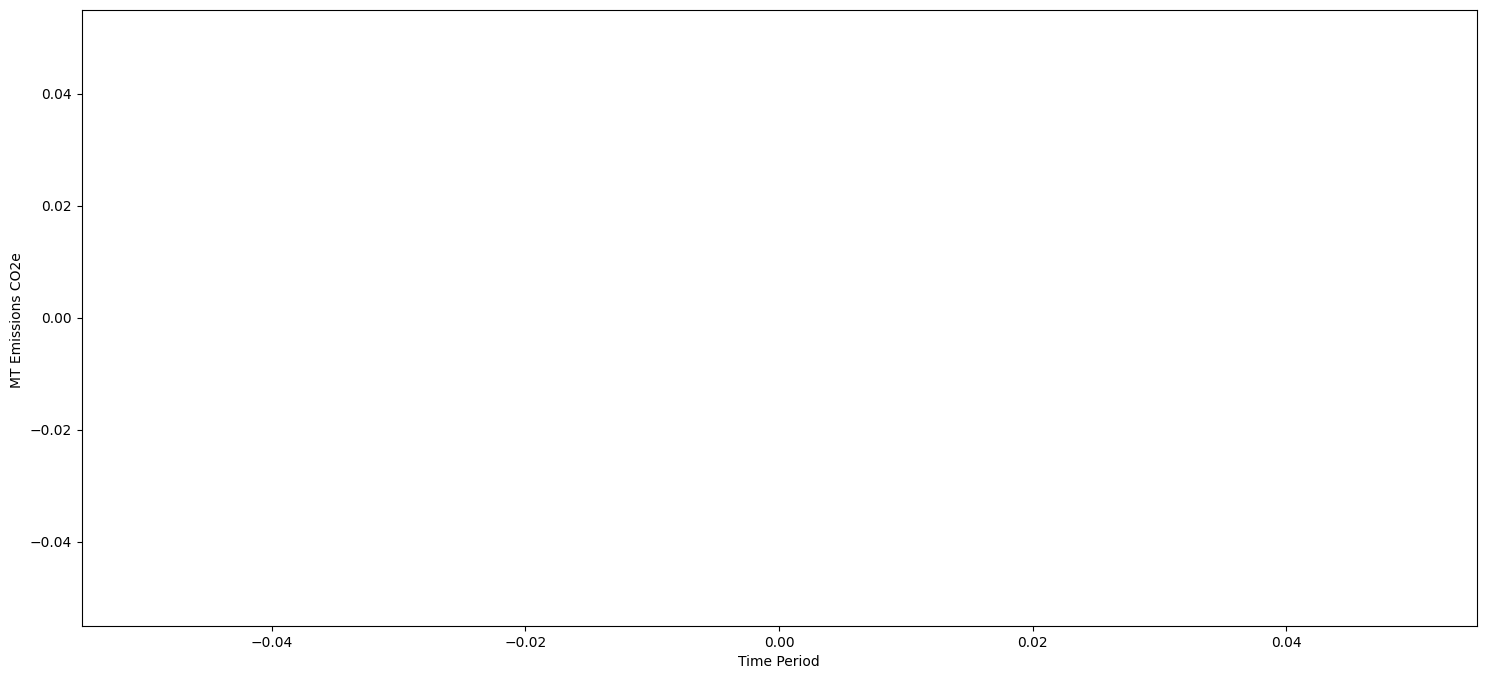

In [54]:

fig, ax = plt.subplots(figsize = (18, 8))
ax.set_xlabel("Time Period")
ax.set_ylabel("MT Emissions CO2e ")

df_plot = df_out[
    df_out[ssp.key_primary].isin([71071])
]


fields = matt.get_all_subsector_emission_total_fields()#[x for x in df_out.columns if (x.startswith("emission_co2e_subsector_total"))]
dict_format = dict(
    (k, {"color": v}) for (k, v) in
    matt.get_subsector_color_map().items()
)

fig, ax = spu.plot_stack(
    df_plot,
    fields,
    dict_formatting = dict_format,
    field_x = "time_period",
    figtuple = (fig, ax),
)



# Export Wide File

In [55]:
df_out = ssp.read_output(None)
df_in = ssp.read_input(None)


all_primaries = sorted(list(df_out[ssp.key_primary].unique()))

# build if unable to simply read the data frame
if df_in is None:
    df_in = []
     
    for region in ssp.regions:
        for primary in all_primaries: 
            df_in_filt = ssp.generate_scenario_database_from_primary_key(primary)
            df_in.append(df_in_filt.get(region))
    
    df_in = pd.concat(df_in, axis = 0).reset_index(drop = True)




df_export = pd.merge(
    df_out,
    df_in,
    how = "left",
)



# check output directory 
dir_pkg = os.path.join(
    ssp.file_struct.dir_out, 
    f"sisepuede_summary_results_run_{ssp.id_fs_safe}"
)
os.makedirs(dir_pkg) if not os.path.exists(dir_pkg) else None


for tab in ["ATTRIBUTE_STRATEGY"]:
    table_df = ssp.database.db.read_table(tab)
    if table_df is not None:
        table_df.to_csv(
            os.path.join(dir_pkg, f"{tab}.csv"),
            index=None,
            encoding="UTF-8"
        )
    else:
        print(f"Warning: Table {tab} returned None.")


df_primary = (
    ssp
    .odpt_primary
    .get_indexing_dataframe(
        sorted(list(df_out[ssp.key_primary].unique()))
    )
)
    
df_primary.to_csv(
    os.path.join(dir_pkg, f"ATTRIBUTE_PRIMARY.csv"),
    index = None,
    encoding = "UTF-8"
)

df_export.to_csv(
    os.path.join(dir_pkg, f"sisepuede_results_{ssp.id_fs_safe}_WIDE_INPUTS_OUTPUTS.csv"),
    index = None,
    encoding = "UTF-8"
)

In [56]:
# Getting the directory where the outputs are stored
ssp.file_struct.dir_out

'/home/tony/miniconda3/envs/ssp-env/lib/python3.11/site-packages/sisepuede/out'

## Some Optional Plotting

In [ ]:
primary_id = 0

df_prim = df_out[
    df_out[
        ssp.key_primary
    ]
    .isin([primary_id])
]

df_in_cur = df_in[
    df_in[
        ssp.key_primary
    ]
    .isin([primary_id])
]


fields_plot = [
    x for x in df_prim.columns
    if "investment" in x
    and df_prim[x].max() > 0
]
(
    df_prim[fields_plot]
    .plot(
        legend = True,
    )
)




In [ ]:


fig, ax = plt.subplots(figsize = (15, 10))
df_resid = matt.extract_model_variable(
    df_in_cur,
    "NemoMod ResidualCapacity"
)
(
    df_resid
    .plot
    .area(
        ax = ax
    )
)

In [ ]:
df_resid

In [ ]:
[x for x in df_out.columns if "capacity" in x]

In [ ]:
ssp.model_attributes.configuration.dict_config


In [ ]:
modvar = matt.get_variable("NemoMod Generation Capacity")
modvar.get_from_dataframe(df_prim).head()

In [ ]:
#[x for x in matt.all_variables if "Consumption" in x]
[x for x in matt.all_variables if "Production" in x]
modvar = matt.get_variable("NemoMod Production by Technology")


unit = matt.get_unit("energy")
(modvar.get_from_dataframe(df_prim).iloc[7].sum()*unit.convert("PJ", "mwh")/1000)/367669

In [ ]:
df_inputs

In [ ]:
modvar = matt.get_variable("Total Energy Consumption from Industrial Energy")#Industrial Energy")
matt.extract_model_variable(
    df_prim,
    modvar
)